# EfficientNet - Implementation from scratch in PyTorch

EfficientNet is a family of convolutional neural networks that were introduced to achieve high accuracy with significantly fewer parameters and lower computational cost.

https://arxiv.org/abs/1905.11946

The authors demonstrated the effect of scaling on the ResNet and MobileNet and they also discovered a whole family of networks called EfficientNet through neural architecture search.

In [ ]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Architecture Implementation

Starting by the fundamental building block of a CNN, represented by a convolutional layer. Notably, the SiLU activation is consistently utilized throughout the entire architecture as mentioned in the original paper.

Groups is specified to control how convolution is applied to input. If group=1, then a kernel is applied to all input channels and if group=in_channel (depthwise convolution), then a single convolutional kernel is applied for each input channel.

In [ ]:
class ConvLayer(nn.Module):
    """
    Implements one customizable CNN layer.
    EfficientNet-style: Input -> Conv2d -> BatchNorm2d -> SiLU -> Output
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1,
                 bias=False, activation=None) -> None:
        super(ConvLayer, self).__init__()
        self.conv= nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias
        )
        # Batch Normalization to stabilize training
        self.norm= nn.BatchNorm2d(out_channels)
        # Activation function -- SiLU is the default in EfficientNet
        self.activation= nn.SiLU() if activation is None else activation


    def forward(self, x):
        x= self.conv(x)
        x= self.norm(x)
        x= self.activation(x)

        return x


The Squeeze-and-Excitation module recalibrates channel-wise feature responses by learning global dependencies. It "squeezes" global spatial information into a channel descriptor using global average pooling (GAP) and then excites (reweights) each channel through a lightweight network. The primary goal is to enhance feature representation by selectively amplifying important channels.

The mechanism applies GAP to condense spatial information into a single descriptor per channel, creating a compact representation of global spatial information. These pooled features are passed to a CNN bottleneck structure and a sigmoid activation is applied on the output features, providing attention weights. The computed attention weights are applied to the original feature maps via channel-wise multiplication, dynamically emphasizing essential channels.

In [ ]:
class SqueezeExcitation(nn.Module):
    """
    Implements a Squeeze-and-Excitation module.
    It squeezes global spatial information into a channel descriptor and re-scales the channels.
    """

    def __init__(self, in_channels, squeezed_dim, activation=None) -> None:
        super(SqueezeExcitation, self).__init__()
        # Global average pooling: C x H x W -> C x 1 x 1
        self.average_pool= nn.AdaptiveAvgPool2d(output_size=(1, 1))
        # 1x1 convolution reduces the channel dimension
        self.conv1= nn.Conv2d(in_channels, squeezed_dim, kernel_size=1)
        # Activation function -- SiLU is the default in EfficientNet
        self.activation= nn.SiLU() if activation is None else activation
        # 1x1 convolution restores the channel dimension
        self.conv2= nn.Conv2d(squeezed_dim, in_channels, kernel_size=1)
        # Sigmoid activation to obtain channel-wise weights between 0 and 1
        self.sigmoid= nn.Sigmoid()


    def forward(self, x):
        se= self.average_pool(x)
        se= self.activation(self.conv1(se))
        se= self.sigmoid(self.conv2(se))

        return x * se


The MBConv consists of inverted residual connections and depthwise separable convolutions, which improve computational efficiency while maintaining high representational power.

The MBConv block includes:

- Expansion Convolution: Expands the input channels using a pointwise (1x1) convolution.
- Depthwise Separable Convolution: A depthwise convolution (operates per channel) followed by a pointwise (1x1) convolution, reducing computational cost.
- Squeeze-and-Excitation: This component applies GAP followed by a lightweight network to generate channel-wise attention weights, which are then applied to the feature maps.
- Stochastic Depth Regularization: Used to improve generalization and training efficiency. It randomly drops entire residual blocks during training, reducing computational load and acting as regularization to prevent overfitting.
- Residual Connection (if input/output dimensions match): Helps with gradient flow and prevents information loss.

In [ ]:
class MBConv(nn.Module):
    """
    Implements a Mobile Inverted Residual Block (inspired by MobileNetV2).
    Residual (skip) connection is used if stride==1 and input/output channels match.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, expand_ratio,
                 reduction=4, survival_prob=0.8, bias=False, activation=None) -> None:
        super(MBConv, self).__init__()
        # Activation function -- SiLU is the default in EfficientNet
        activation= nn.SiLU() if activation is None else activation
        hidden_dim= in_channels * expand_ratio
        # For squeeze and excitation module
        reduced_dim= in_channels // reduction

        self.use_residual= (in_channels == out_channels) and (stride == 1)
        # Determine if expansion is needed
        self.expand= (in_channels != hidden_dim)
        # For stochastic depth
        self.survival_prob= survival_prob

        if self.expand:
            # Optional expansion phase (1x1 conv + BN + Activation)
            self.expand_conv= ConvLayer(
                in_channels, hidden_dim, kernel_size=1, stride=1, padding=0, bias=bias,
                activation=activation
            )

        self.conv= nn.Sequential(
            # Depthwise convolution
            ConvLayer(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
                bias=bias, activation=activation
            ),
            # Squeeze-and-Excitation
            SqueezeExcitation(hidden_dim, reduced_dim, activation=activation),
            # Projection phase (1x1 conv + BN) -- reduce channels to out_channels
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels),
        )


    def stochastic_depth(self, x):
        """
        Implements stochastic depth regularization.
        During training, randomly drops the output of the block with probability
        (1 - survival_prob) scaling the remaining output to maintain the expected value.
        """
        if not self.training:
            return x
        # Binary mask with the same batch size and shape (broadcasted over spatial dimensions)
        binary_tensor= torch.rand(
            x.shape[0], 1, 1, 1, device=x.device, dtype=x.dtype
        ) < self.survival_prob
        # Scale the output to maintain expected value and apply the mask
        return torch.div(x, self.survival_prob) * binary_tensor


    def forward(self, x):
        # Save the original input for the residual connection -- avoid in-place operations
        identity= x
        if self.expand:
            x= self.expand_conv(x)
        # Compute the main branch convolutions
        x= self.conv(x)
        if self.use_residual:
            return identity + self.stochastic_depth(x)

        return x


# Define configs for different EfficientNet versions

The motivation behind introducing $\phi$ lies in the understanding that increasing the depth of the model linearly impacts the FLOPS, while changing the width or resolution has a quadratic impact. These constants were derived through neural architecture search, drawing inspiration from MnasNet.

In [ ]:
base_model= [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values= {
    # model_version: (phi_value, resolution, dropout)
    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

# Building the EfficientNet

**Stem and Head**

- Stem: The network begins with a standard convolutional layer (with stride 2) to reduce spatial resolution.
- Head: After the MBConv blocks, a final 1x1 convolution, GAP, and a fully connected layer (classifier) are applied to produce the final predictions.

**Compound Scaling**: One of the major contributions of EfficientNet is its compound scaling method. Instead of scaling only one dimension (e.g., depth or width), EfficientNet scales all three dimensions (depth, width, and resolution) in a principled manner using a compound coefficient $\phi$.

- Depth Scaling: Increases the number of layers (blocks) in the network.
- Width Scaling: Increases the number of channels (filters) in each layer.
- Resolution Scaling: Increases the input image size.

In [ ]:
class EfficientNet(nn.Module):
    """
    EfficientNet implementation using MBConv blocks with compound scaling.
    The scaling factors (width and depth) are computed based on the provided model_version.
    """

    def __init__(self, model_version, in_channels, num_classes, bias=False, activation=None,
                 reduction=4, survival_prob=0.8, alpha=1.2, beta=1.1) -> None:
        super(EfficientNet, self).__init__()
        # Activation function -- SiLU is the default in EfficientNet
        activation= nn.SiLU() if activation is None else activation
        # Get scaling factors from the provided model_version
        width_factor, depth_factor, resolution, dropout= self.model_factors(
            model_version, alpha, beta
        )
        # Base channels scaled by width_factor.
        stem_channels= int(32 * width_factor)
        # Final channel dimension, scaled and rounded up to a multiple of the reduction factor
        last_channels= math.ceil(1280 * width_factor)

        # Build the backbone feature extractor
        self.backbone= nn.ModuleList([
            # Stem: Initial 3x3 conv with stride 2
            ConvLayer(
                in_channels, stem_channels, kernel_size=3, stride=2, padding=1,
                bias=bias, activation=activation
            )
        ])
        # Update in_channels for subsequent layers
        in_channels= stem_channels

        # MBConv layers
        # For each layer in the base_model, scale the number of channels and number of repeats
        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            # Scale the out_channels using width_factor and round up to a multiple of the reduction
            out_channels = reduction * math.ceil(int(channels * width_factor) / reduction)
            layer_repeats= math.ceil(repeats * depth_factor)

            for layer in range(layer_repeats):
                # The first layer in a block uses the specified stride; for others, use stride 1
                stride= stride if layer== 0 else 1
                # Calculate padding to maintain spatial dimensions
                padding= kernel_size // 2

                self.backbone.append(
                    MBConv(
                        in_channels, out_channels, kernel_size, stride, padding, expand_ratio,
                        reduction, survival_prob, bias=bias, activation=activation
                    )
                )
                # Update in_channels for subsequent layers
                in_channels= out_channels

        self.backbone.append(
            # Head: Final 1x1 conv to adjust channel dimension before classification
            ConvLayer(
                in_channels, last_channels, kernel_size=1, stride=1, padding=0,
                bias=bias, activation=activation
            )
        )

        # Pooling and classification head to produce the class logits
        self.pool= nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.head= nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(last_channels, num_classes),
        )

        # initialize parameters with Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def model_factors(self, model_version, alpha, beta):
        """
        Computes scaling factors for width and depth based on the EfficientNet compound scaling
        method.
        """
        phi, resolution, dropout= phi_values[model_version]
        depth_factor= alpha ** phi
        width_factor= beta ** phi

        return width_factor, depth_factor, resolution, dropout


    def forward(self, x):
        for layer in self.backbone:
            x= layer(x)
        x= self.pool(x)
        x= torch.flatten(x, start_dim=1)
        x= self.head(x)

        return x


In [ ]:
img= torch.randn(1, 3, 224, 224).to(device)  # a single image batch
model= EfficientNet(model_version='b0', in_channels=3, num_classes=1000).to(device)
count_parameters(model)
print(model(img).shape)

model

Number of parameters: 5288548
torch.Size([1, 1000])


EfficientNet(
  (backbone): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (1): MBConv(
      (conv): Sequential(
        (0): ConvLayer(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): SiLU()
        )
        (1): SqueezeExcitation(
          (average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
          (conv1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU()
          (conv2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (sigmoid): Sigmoid()
        )
        (2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(16, e

# Training a EfficientNet model from scratch

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [ ]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std= [0.2023, 0.1994, 0.2010]), # CIFAR-10 stats
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 128
train_loader= DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 80.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(train_loader), len(val_loader)

(352, 40)

# Trainer Function

TODO:

- Data augmentation for training.
- Play with different learning rate values.

In [ ]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, eval_interval=1, verbose=False):

    tr_loss_hist= []
    vl_loss_hist= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        batch_loss= []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            # --- minibatch construction ---
            images= images.to(device, non_blocking=True)
            labels= labels.to(device, non_blocking=True)

            # --- forward pass and get loss ---
            logits= model(images)
            loss= criterion(logits, labels)
            batch_loss.append(loss.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.to(device), labels.to(device)
                    logits= model(images)
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            val_loss= np.mean(val_loss)
            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")

            # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
            scheduler.step(val_loss)

        vl_loss_hist.append(val_loss)

    return tr_loss_hist, vl_loss_hist


In [ ]:
def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    correct= 0
    total= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            logits= model(images)
            y_pred= torch.argmax(logits, dim=1)
            correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    acc= correct / total
    if verbose:
        print(f"Accuracy: {(acc * 100):.2f}%")

    return acc


In [ ]:
def plot_losses(train_loss, valid_loss):
    # plot training and validation losses
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

# Training setup using TF32 and Fused AdamW

In [ ]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available

# --- EfficientNet-B0 ---
version= 'b0'
in_channels= 3
num_classes= 10

model= EfficientNet(version, in_channels, num_classes).to(device)
count_parameters(model)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 5e-4

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss()
# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

Number of parameters: 4020358
Using fused AdamW: True


In [ ]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 1.6824 | Val Loss: 1.2501 | dt/epoch: 90036.27ms
Epoch: 1 | Train Loss: 1.1130 | Val Loss: 0.9281 | dt/epoch: 89734.73ms
Epoch: 2 | Train Loss: 0.8305 | Val Loss: 0.6867 | dt/epoch: 89706.46ms
Epoch: 3 | Train Loss: 0.6528 | Val Loss: 0.5763 | dt/epoch: 89796.05ms
Epoch: 4 | Train Loss: 0.5467 | Val Loss: 0.5430 | dt/epoch: 89424.69ms
Epoch: 5 | Train Loss: 0.4646 | Val Loss: 0.4712 | dt/epoch: 89698.81ms
Epoch: 6 | Train Loss: 0.4063 | Val Loss: 0.4271 | dt/epoch: 89509.06ms
Epoch: 7 | Train Loss: 0.3557 | Val Loss: 0.4251 | dt/epoch: 89388.36ms
Epoch: 8 | Train Loss: 0.3214 | Val Loss: 0.3921 | dt/epoch: 89438.52ms
Epoch: 9 | Train Loss: 0.2803 | Val Loss: 0.3833 | dt/epoch: 89850.75ms
Epoch: 10 | Train Loss: 0.2542 | Val Loss: 0.3962 | dt/epoch: 89291.72ms
Epoch: 11 | Train Loss: 0.2227 | Val Loss: 0.3756 | dt/epoch: 89563.09ms
Epoch: 12 | Train Loss: 0.1977 | Val Loss: 0.4002 | dt/epoch: 89699.89ms
Epoch: 13 | Train Loss: 0.1728 | Val Loss: 0.4038 | dt/epoch:

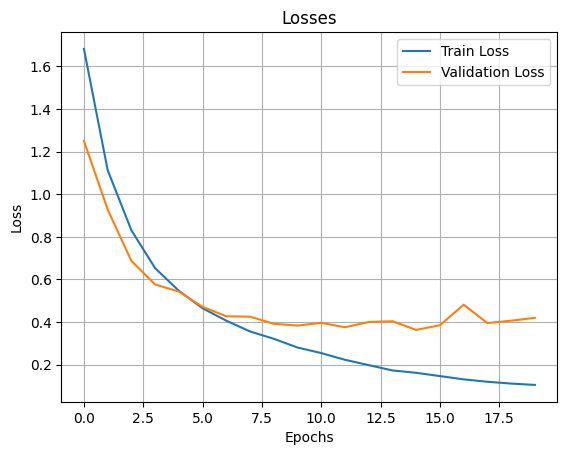

In [ ]:
# plot
plot_losses(tr_loss, vl_loss)

In [ ]:
effnet_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 87.76%


In [ ]:
# https://medium.com/@aniketthomas27/efficientnet-implementation-from-scratch-in-pytorch-a-step-by-step-guide-a7bb96f2bdaa
# https://amaarora.github.io/posts/2020-08-13-efficientnet.html
# https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_efficientnet.py
# https://medium.com/technological-singularity/efficientnet-revolutionizing-deep-learning-through-model-efficiency-0ed5485f9a6f